<a href="https://colab.research.google.com/github/drewwint/neuromatch-2021/blob/Project/plots_HCP_emot-social.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drew Edited
##  Load HCP parcellated task data

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

In [ ]:
print(EXPERIMENTS)

{'MOTOR': {'runs': [5, 6], 'cond': ['lf', 'rf', 'lh', 'rh', 't', 'cue']}, 'WM': {'runs': [7, 8], 'cond': ['0bk_body', '0bk_faces', '0bk_places', '0bk_tools', '2bk_body', '2bk_faces', '2bk_places', '2bk_tools']}, 'EMOTION': {'runs': [9, 10], 'cond': ['fear', 'neut']}, 'GAMBLING': {'runs': [11, 12], 'cond': ['loss', 'win']}, 'LANGUAGE': {'runs': [13, 14], 'cond': ['math', 'story']}, 'RELATIONAL': {'runs': [15, 16], 'cond': ['match', 'relation']}, 'SOCIAL': {'runs': [17, 18], 'cond': ['mental', 'rnd']}}


> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [ ]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
print(fname)

hcp_task.tgz


## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [ ]:
print(regions)

[['R_V1' 'R_MST' 'R_V6' ... 'L_PI' 'L_a32pr' 'L_p24']
 ['Visual1' 'Visual2' 'Visual2' ... 'Cingulo-Oper' 'Cingulo-Oper'
  'Cingulo-Oper']
 ['2.209' '2.05561' '2.1498' ... '1.74335' '1.73082' '1.65968']]


# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task. 

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = EXPERIMENTS[experiment]['runs'][run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list



In [ ]:

#myfiles=range(0,339)

#for x in myfiles:
#  print(x)



# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [ ]:
my_exp  = 'SOCIAL'
my_subj = 0
my_run  = 1

socialdata = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
print(socialdata.shape)

(360, 274)


In [ ]:
print(socialdata)

[[  75.67226277   32.97226277   37.97226277 ...  -30.32773723
   -93.42773723 -115.12773723]
 [ -32.39310219  -31.67310219  -28.91310219 ...    8.39689781
   -51.20310219  -61.97310219]
 [  81.58175182   64.28175182   58.08175182 ...   44.88175182
    21.98175182  -47.51824818]
 ...
 [  68.94452555   21.64452555  141.74452555 ...    1.14452555
  -133.85547445   50.84452555]
 [  27.1770073   132.9770073   125.8770073  ...  -44.8229927
    -0.4229927  -112.1229927 ]
 [ 176.15036496  114.35036496  119.55036496 ...   28.35036496
   118.75036496  -32.34963504]]


As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

### here we are loading all participants into 1 large matrix

In [ ]:

my_exp  = 'SOCIAL'
data = {}
my_run  = 1
for my_subj in range(0,339):
  if my_subj == 0:
    k = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
    data = k
  else:
    k = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
    #data = np.concatenate(data,k)
    data = np.concatenate((data,k), axis=0)
print(data.shape)



(122040, 274)


In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions. 

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [ ]:
# we need a little function that averages all frames from any given condition

def average_frames(socialdata, evs, experiment, cond):    
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(socialdata[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)


mental_activity = average_frames(socialdata, evs, my_exp, 'mental')
rnd_activity = average_frames(socialdata, evs, my_exp, 'rnd')

contrast    = mental_activity-rnd_activity   # difference between left and right hand movement

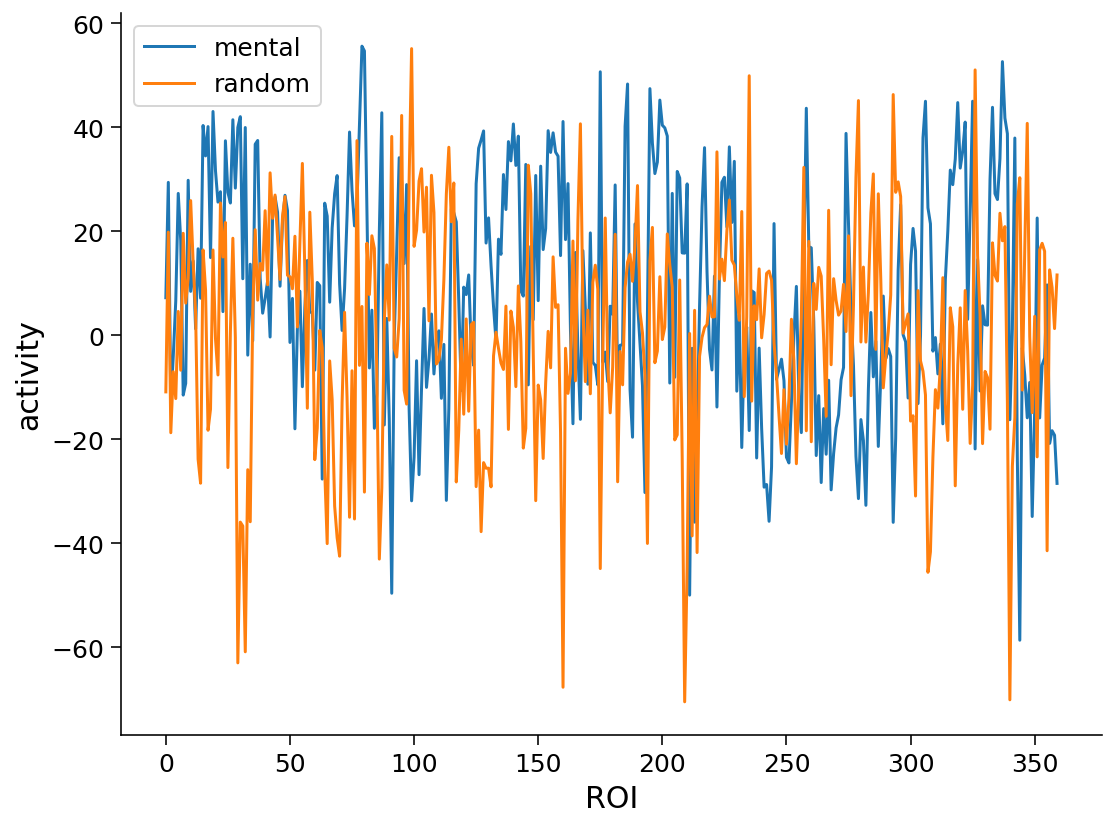

In [ ]:
# Plot activity level in each ROI for both conditions
plt.plot(mental_activity,label='mental')
plt.plot(rnd_activity,label='random')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





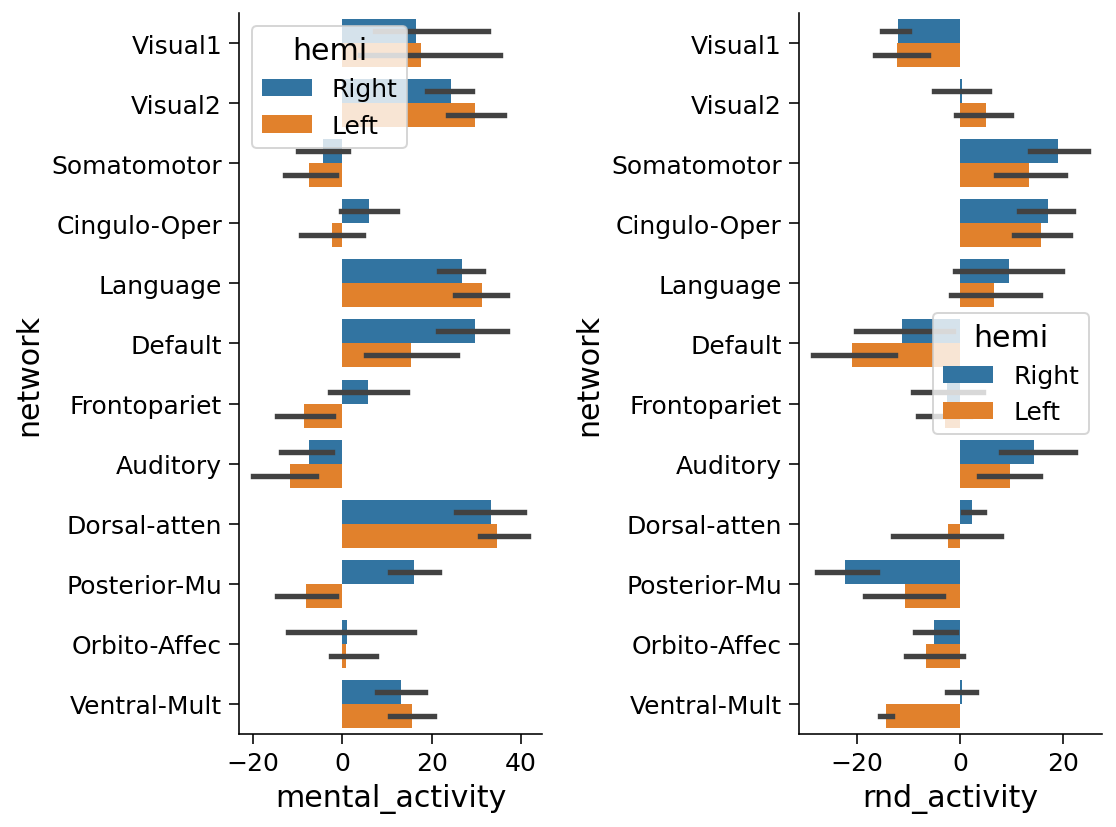

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'mental_activity' : mental_activity,
                   'rnd_activity' : rnd_activity,
                   'network'     : region_info['network'],
                   'hemi'        : region_info['hemi']})

fig,(ax1,ax2) = plt.subplots(1,2)
sns.barplot(y='network', x='mental_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='rnd_activity', data=df, hue='hemi',ax=ax2)




In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mental_activity  360 non-null    float64
 1   rnd_activity     360 non-null    float64
 2   network          360 non-null    object 
 3   hemi             360 non-null    object 
dtypes: float64(2), object(2)
memory usage: 11.4+ KB
None


You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be suubtle at the single subject/session level (these are a quick 3-4min scans). 


Let us boost thee stats by averaging across all subjects and runs. 

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0,1]:
    data = load_single_timeseries(subject=s,experiment=my_exp,run=r,remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    lf_activity = average_frames(data, evs, my_exp, 'mental')
    rf_activity = average_frames(data, evs, my_exp, 'rnd')

    contrast    = lf_activity-rf_activity
    group_contrast        += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject



In [ ]:
group_contrast.shape

(360,)

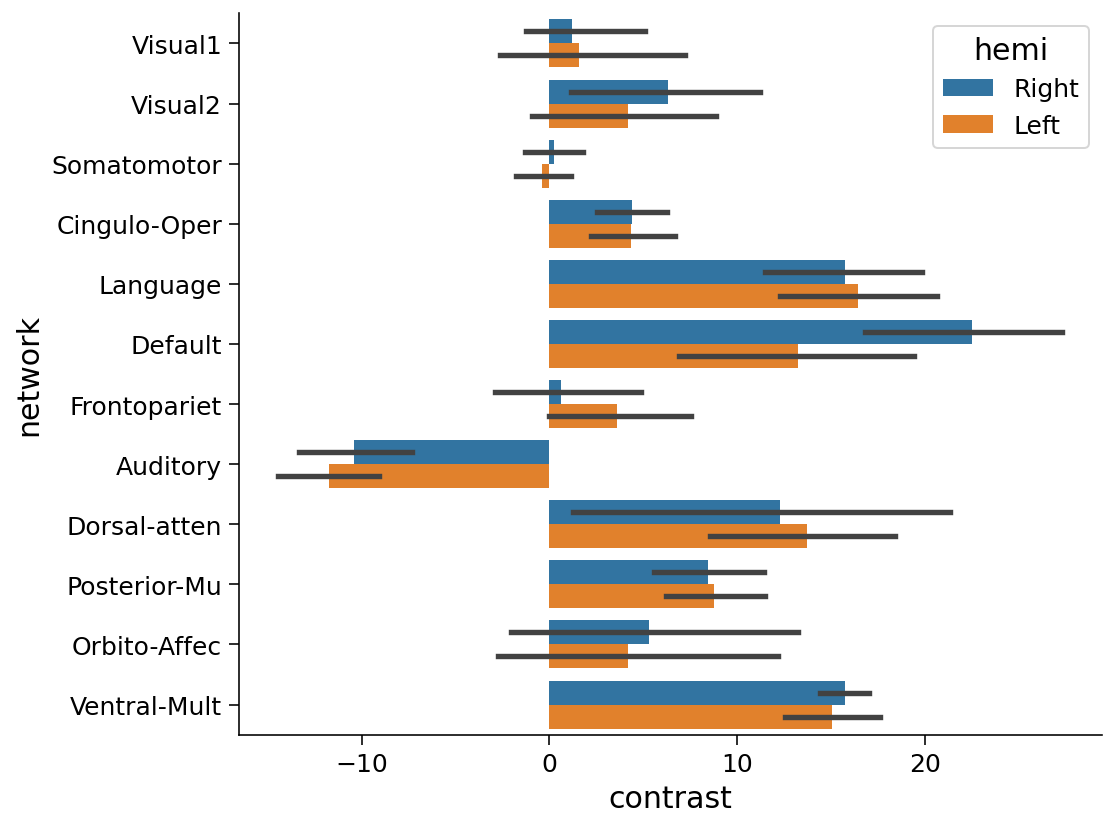

In [ ]:

df = pd.DataFrame({'contrast':group_contrast,'network':region_info['network'],'hemi':region_info['hemi']})
# we will plot the left foot minus right foot contrast so we only need one plot
sns.barplot(y='network', x='contrast', data=df, hue='hemi')




In [ ]:
#group_contrast = 0
for s in subjects:
  for r in [0,1]:
    data = load_single_timeseries(subject=s,experiment=my_exp,run=r,remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    mental_activity = average_frames(data, evs, my_exp, 'mental')
    rnd_activity = average_frames(data, evs, my_exp, 'rnd')
    #fear_cond = average_frames(socialdata, evs, my_exp, 'fear')
    #neutral_cond = average_frames(socialdata, evs, my_exp, 'neut')

    #contrast    = lf_activity-rf_activity
    #group_contrast        += contrast

#group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject





In [ ]:
my_exp3= 'EMOTION'
#group_contrast = 0
for s in subjects:
  for r in [0,1]:
    data3 = load_single_timeseries(subject=s,experiment=my_exp,run=r,remove_mean=True)
    evs3 = load_evs(subject=s, experiment=my_exp,run=r)

    #mental_activity = average_frames(data, evs, my_exp, 'mental')
    #rnd_activity = average_frames(data, evs, my_exp, 'rnd')
    fear_cond = average_frames(socialdata, evs3, my_exp3, 'fear')
    neutral_cond = average_frames(socialdata, evs3, my_exp3, 'neut')

    #contrast    = lf_activity-rf_activity
    #group_contrast        += contrast

#group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

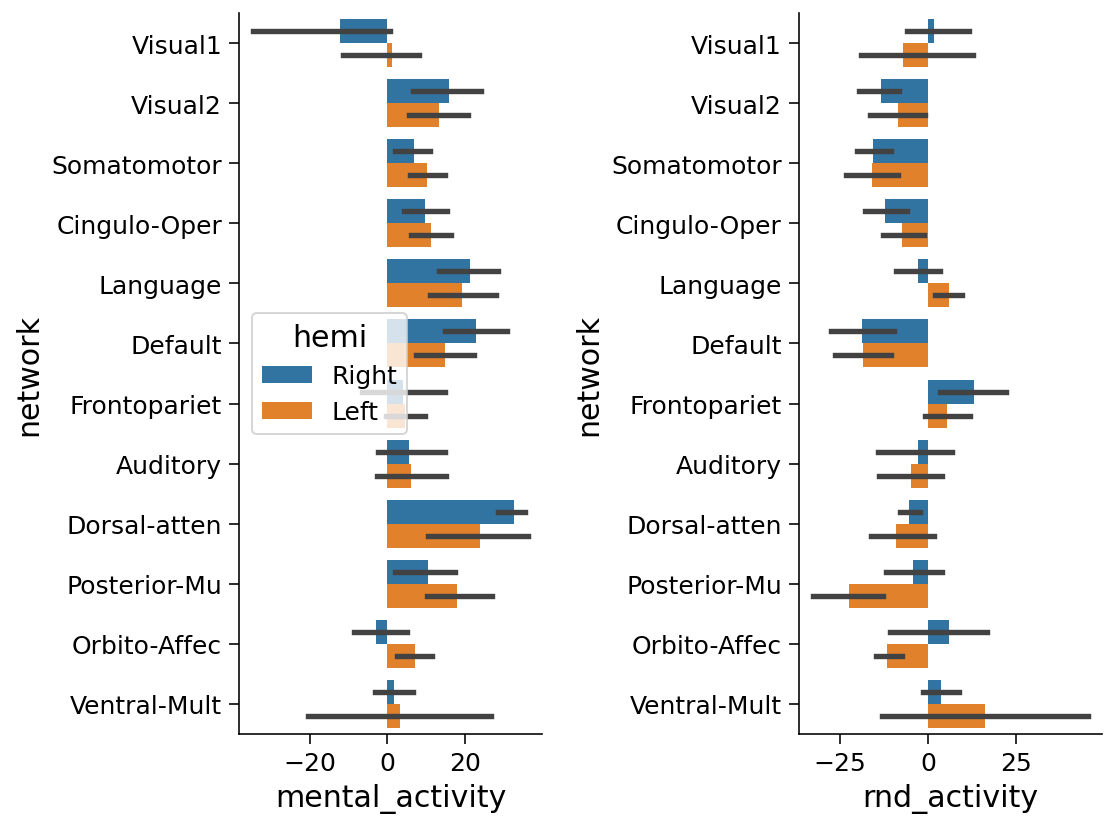

In [ ]:
df2 = pd.DataFrame({'fear_cond' : fear_cond, 'neutral_cond' : neutral_cond,'mental_activity' : mental_activity, 'rnd_activity' : rnd_activity,'network':region_info['network'],'hemi':region_info['hemi']})
# we will plot the left foot minus right foot contrast so we only need one plot
fig,(ax1,ax2) = plt.subplots(1,2)
sns.barplot(y='network', x='mental_activity', data=df2, hue='hemi',ax=ax1)
sns.barplot(y='network', x='rnd_activity', data=df2, hue='hemi',ax=ax2)
plt.legend([],[], frameon=False)



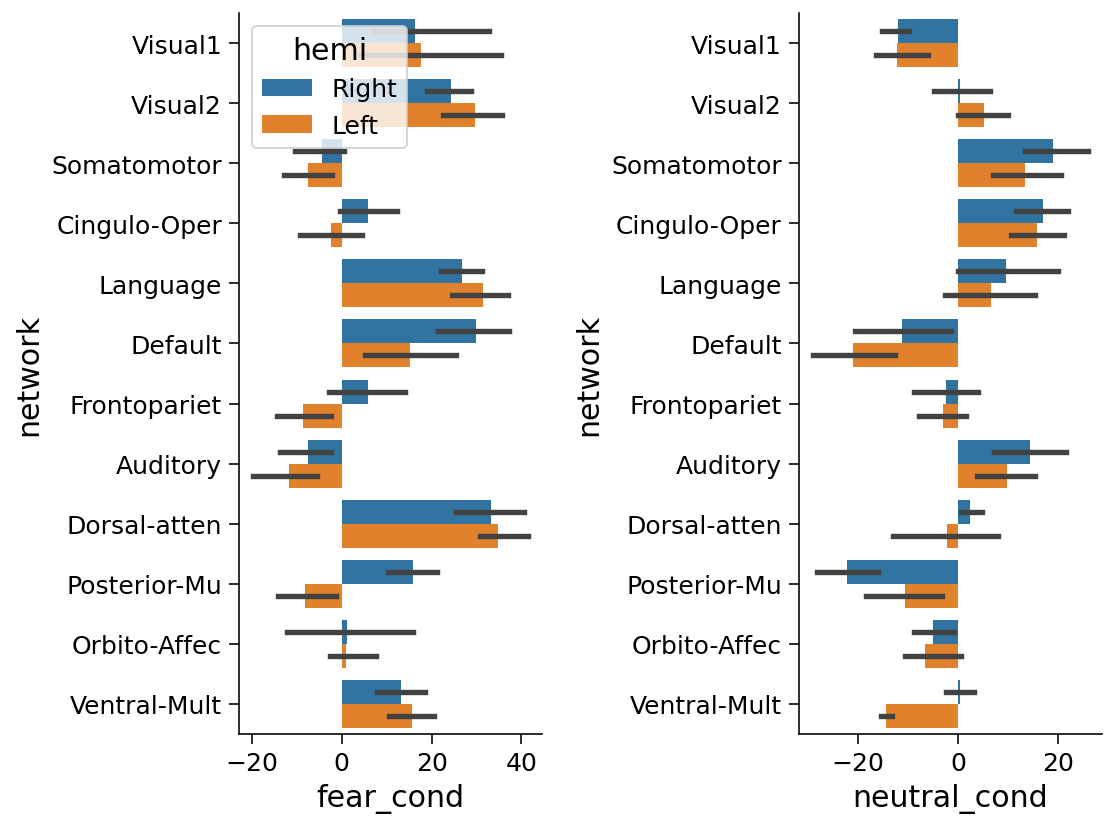

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2)
sns.barplot(y='network', x='fear_cond', data=df2, hue='hemi',ax=ax1)
sns.barplot(y='network', x='neutral_cond', data=df2, hue='hemi',ax=ax2)
plt.legend([],[], frameon=False)


# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:

# This uses the nilearn package
!pip install nilearn --quiet
from nilearn import plotting, datasets

# NMA provides an atlas 
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download
with np.load(fname) as dobj:
  atlas = dict(**dobj)

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

TypeError: ignored